# Rapport d'optimisation de reservoir

Dans ce notebook on reprend les phases principales de notre optimisation d'un modèle de réseau de neurones avec la bibliotèque Reservoirpy.

On commence par installer la bibliotèque, importer les fonctions nécessaires et choisir une seed pour garantir la reproductibilité des resultats.

In [ ]:
%pip install reservoirpy

In [ ]:
import reservoirpy
from reservoirpy import ESN
from reservoirpy.observables import nrmse, rsquare
from reservoirpy.hyper import research, plot_hyperopt_report, parallel_research
from reservoirpy.nodes import Reservoir, Ridge
from dataset_prep import init_dataset
import numpy as np
import matplotlib.pyplot as plt

reservoirpy.set_seed(96)

Les données sont chargées dans des tableaux numpy grâce à une fonction annexe qui les formate correctement.

Elles sont réparties en 3 sets. Dans ce notebook seul le set A est utilisé mais les autres sont disponibles.

In [ ]:
SET_A, SET_B, SET_C = init_dataset("dst_labels.csv")

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(10, 9))
axs[0].set_title("Preview of the normalized DST signal")
axs[0].plot(SET_A)
axs[0].set_ylabel("$DST$")
axs[0].set_xlabel("$t (days)$")
axs[1].plot(SET_B)
axs[1].set_ylabel("$DST$")
axs[1].set_xlabel("$t (days)$")
axs[2].plot(SET_C)
axs[2].set_ylabel("$DST$")
axs[2].set_xlabel("$t (days)$")
plt.show()

Afin de facilement changer le fractionnement des données utilisées la fonction generate_data(data, nb_training_points, nb_test_points, pas) est définie

In [ ]:
def generate_data(data, nb_training_points, nb_test_points, pas):
    x_train = data[0:nb_training_points]
    y_train = data[pas : nb_training_points+pas]
    x_test = data[nb_training_points : nb_training_points + nb_test_points]
    y_test = data[nb_training_points + pas : nb_training_points + pas + nb_test_points]
    return x_train, x_test, y_train, y_test

Elle permet donc de construire un premier dataset contenant 8000 point d'entrainement pour le model et 100 points de verification afin de voir la prédiction du modèle sur des données inédites. Etant donné que la prédiction sur 1 jour était plutôt simple pour notre modèle nous avons choisi de viser une prévision sur 10 jours afin de voir une véritable amélioration.

In [ ]:
nb_training_points = 8000
nb_test_points = 100
pas = 10

x_train, x_test, y_train, y_test = generate_data(SET_A, nb_training_points, nb_test_points, pas)

In [ ]:
plt.figure(figsize=(10, 3))
plt.title("Preview of the input and expected prediction")
plt.ylabel("$DST$")
plt.xlabel("$t (days)$")
plt.plot(y_train[:min(len(y_train), 100)], label="training expected output", color="blue")
plt.plot(x_train[:min(len(x_train), 100)], label="training input", color="red")
plt.legend()
plt.show()

Notre premier modèle reprend les hyperparamètres de base du tutoriel afin d'avoir un premier jet et une référence à comparer avec le modèle optimal.

Cette différence pourra être observée via la courbe de différence entre la prédiction et la réalité mais surtout via l'erreur RMS.

In [ ]:
model = ESN(units=500, 
            sr=0.9, 
            lr=0.5,
            ridge=1e-6, 
            input_scaling=2.0)

model = model.fit(x_train, y_train)
y_pred = model.run(x_test)

loss = nrmse(x_test, y_pred, norm_value=np.ptp(x_train))

In [ ]:
plt.figure(figsize=(10, 3))
plt.title("ESN prediction on the normalized DST signal")
plt.ylabel("$DST$")
plt.xlabel("$t (days)$")
plt.plot(x_test, label="real", color="blue")
plt.plot(y_pred, label="predicted", color="red")
plt.legend()
plt.show()

plt.figure(figsize=(10, 3))
plt.title("Difference between prediction and real signal")
plt.ylabel("$difference$")
plt.xlabel("$t (days)$")
plt.plot(abs(y_pred-x_test))
plt.show()

print(f"NRMSE loss on test set: {loss}")

## Optimisation

Cette partie concerne la recherche des hyper paramètres optimaux pour notre application.

Pour l'automatisation de cette recherche on a besoin d'une fonction qui détermine les performances d'un set d'hyperparamètres. La fonction donnée dans le tutoriel correspond parfaitement à notre application.

In [ ]:
def objective(dataset, config, *, input_scaling, N, sr, lr, ridge, seed):
    # This step may vary depending on what you put inside 'dataset'
    x_train, x_test, y_train, y_test = dataset

    # You can access anything you put in the config
    # file from the 'config' parameter.
    instances = config["instances_per_trial"]

    # The seed should be changed across the instances,
    # to be sure there is no bias in the results
    # due to initialization.
    variable_seed = seed

    losses = []; r2s = [];
    for n in range(instances):
        # Build your model given the input parameters
        reservoir = Reservoir(
            units=N,
            sr=sr,
            lr=lr,
            input_scaling=input_scaling,
            seed=variable_seed
        )

        readout = Ridge(ridge=ridge)

        model = reservoir >> readout


        # Train your model and test your model.
        predictions = model.fit(x_train, y_train) \
                           .run(x_test)

        loss = nrmse(y_test, predictions, norm_value=np.ptp(x_train))
        r2 = rsquare(y_test, predictions)

        # Change the seed between instances
        variable_seed += 1

        losses.append(loss)
        r2s.append(r2)

    # Return a dictionnary of metrics. The 'loss' key is mandatory when
    # using hyperopt.
    return {'loss': np.mean(losses),
            'r2': np.mean(r2s)}

On fait ensuite une recherche d'hyperparamètres parallélisée. 

Les paramètres de cette recherche aléatoire sont les suivants : 
- nombres d'itérations : 200
- nombre de modèles par itération : 5
- nombre de neurones : 500
- intervalle de rayon spectral : [0.01 , 10]
- intervalle de taux de fuite : [0.001, 1]
- intervalle de ridge : [1e-8 , 10]

In [ ]:
import json

hyperopt_config = {
    "exp": "hyperopt-multiscroll",    # the experimentation name
    "hp_max_evals": 200,              # the number of differents sets of parameters hyperopt has to try
    "hp_method": "random",            # the method used by hyperopt to chose those sets (see below)
    "seed": 96,                       # the random state seed, to ensure reproducibility
    "instances_per_trial": 5,         # how many random ESN will be tried with each sets of parameters
    "hp_space": {                     # what are the ranges of parameters explored
        "N": ["choice", 500],             # the number of neurons is fixed to 500
        "sr": ["loguniform", 1e-2, 10],   # the spectral radius is log-uniformly distributed between 1e-2 and 10
        "lr": ["loguniform", 1e-3, 1],    # idem with the leaking rate, from 1e-3 to 1
        "input_scaling": ["choice", 1.0], # the input scaling is fixed
        "ridge": ["loguniform", 1e-8, 1e1],        # and so is the regularization parameter.
        "seed": ["choice", 80085]          # an other random seed for the ESN initialization
    }
}

# we precautionously save the configuration in a JSON file
# each file will begin with a number corresponding to the current experimentation run number.
with open(f"{hyperopt_config['exp']}.config.json", "w+") as f:
    json.dump(hyperopt_config, f)

nb_training_points = 5000
nb_test_points = 2000
pas = 10

x_train, x_test, y_train, y_test = generate_data(SET_A, nb_training_points, nb_test_points, pas) 
dataset = (x_train, x_test, y_train, y_test)

best = parallel_research(objective, dataset, f"{hyperopt_config['exp']}.config.json", ".")

fig = plot_hyperopt_report(hyperopt_config["exp"], ("lr", "sr", "ridge"), metric="r2")
plt.show()

Après les résultats de la première recherche, une deuxième a été conduite avec des intervalles afinés

In [ ]:
hyperopt_config = {
    "exp": "hyperopt-multiscroll",    # the experimentation name
    "hp_max_evals": 200,              # the number of differents sets of parameters hyperopt has to try
    "hp_method": "random",            # the method used by hyperopt to chose those sets (see below)
    "seed": 96,                       # the random state seed, to ensure reproducibility
    "instances_per_trial": 5,         # how many random ESN will be tried with each sets of parameters
    "hp_space": {                     # what are the ranges of parameters explored
        "N": ["choice", 500],             # the number of neurons is fixed to 500
        "sr": ["loguniform", 1e-2, 10],   # the spectral radius is log-uniformly distributed between 1e-2 and 10
        "lr": ["loguniform", 1e-1, 1],    # idem with the leaking rate, from 1e-3 to 1
        "input_scaling": ["choice", 1.0], # the input scaling is fixed
        "ridge": ["loguniform", 1e-8, 1e1],        # and so is the regularization parameter.
        "seed": ["choice", 80085]          # an other random seed for the ESN initialization
    }
}

# we precautionously save the configuration in a JSON file
# each file will begin with a number corresponding to the current experimentation run number.
with open(f"{hyperopt_config['exp']}.config.json", "w+") as f:
    json.dump(hyperopt_config, f)

nb_training_points = 5000
nb_test_points = 2000
pas = 10

x_train, x_test, y_train, y_test = generate_data(SET_A, nb_training_points, nb_test_points, pas)  
dataset = (x_train, x_test, y_train, y_test)

best = parallel_research(objective, dataset, f"{hyperopt_config['exp']}.config.json", ".")

fig = plot_hyperopt_report(hyperopt_config["exp"], ("lr", "sr", "ridge"), metric="r2")
plt.show()

D'après les résultats les hyperparamètres optimaux sont :
- sr = 0.5
- lr = 1
- ridge = 1e-5

Voici donc la prédiction avec le nouveau modèle entrainé : 

In [ ]:
nb_training_points = 8000
nb_test_points = 100
pas = 10

x_train, x_test, y_train, y_test = generate_data(SET_A, nb_training_points, nb_test_points, pas)

model = ESN(units=1000, 
            sr=0.5, 
            lr=1.0,
            ridge=1e-5, 
            input_scaling=1.0)

model = model.fit(x_train, y_train)
y_pred = model.run(x_test)

loss = nrmse(x_test, y_pred, norm_value=np.ptp(x_train))

In [ ]:

plt.figure(figsize=(10, 3))
plt.title("New ESN prediction")
plt.ylabel("$DST$")
plt.xlabel("$t (days)$")
plt.plot(x_test, label="real", color="blue")
plt.plot(y_pred, label="predicted", color="red")
plt.legend()
plt.show()

plt.figure(figsize=(10, 3))
plt.title("Difference between prediction and real signal")
plt.ylabel("$difference$")
plt.xlabel("$t (days)$")
plt.plot(abs(y_pred-x_test))
plt.show()

print(f"NRMSE loss on test set: {loss}")

Pour finir nous avons fait une dernière recherche avec plus de neurone et en se focalisant seulement sur l'impact du ridge mais les résultats montrent que le choix de 1e-5 était déjà judicieux.

100%|██████████| 100/100 [01:32<00:00,  1.08trial/s, best loss=0.0853]


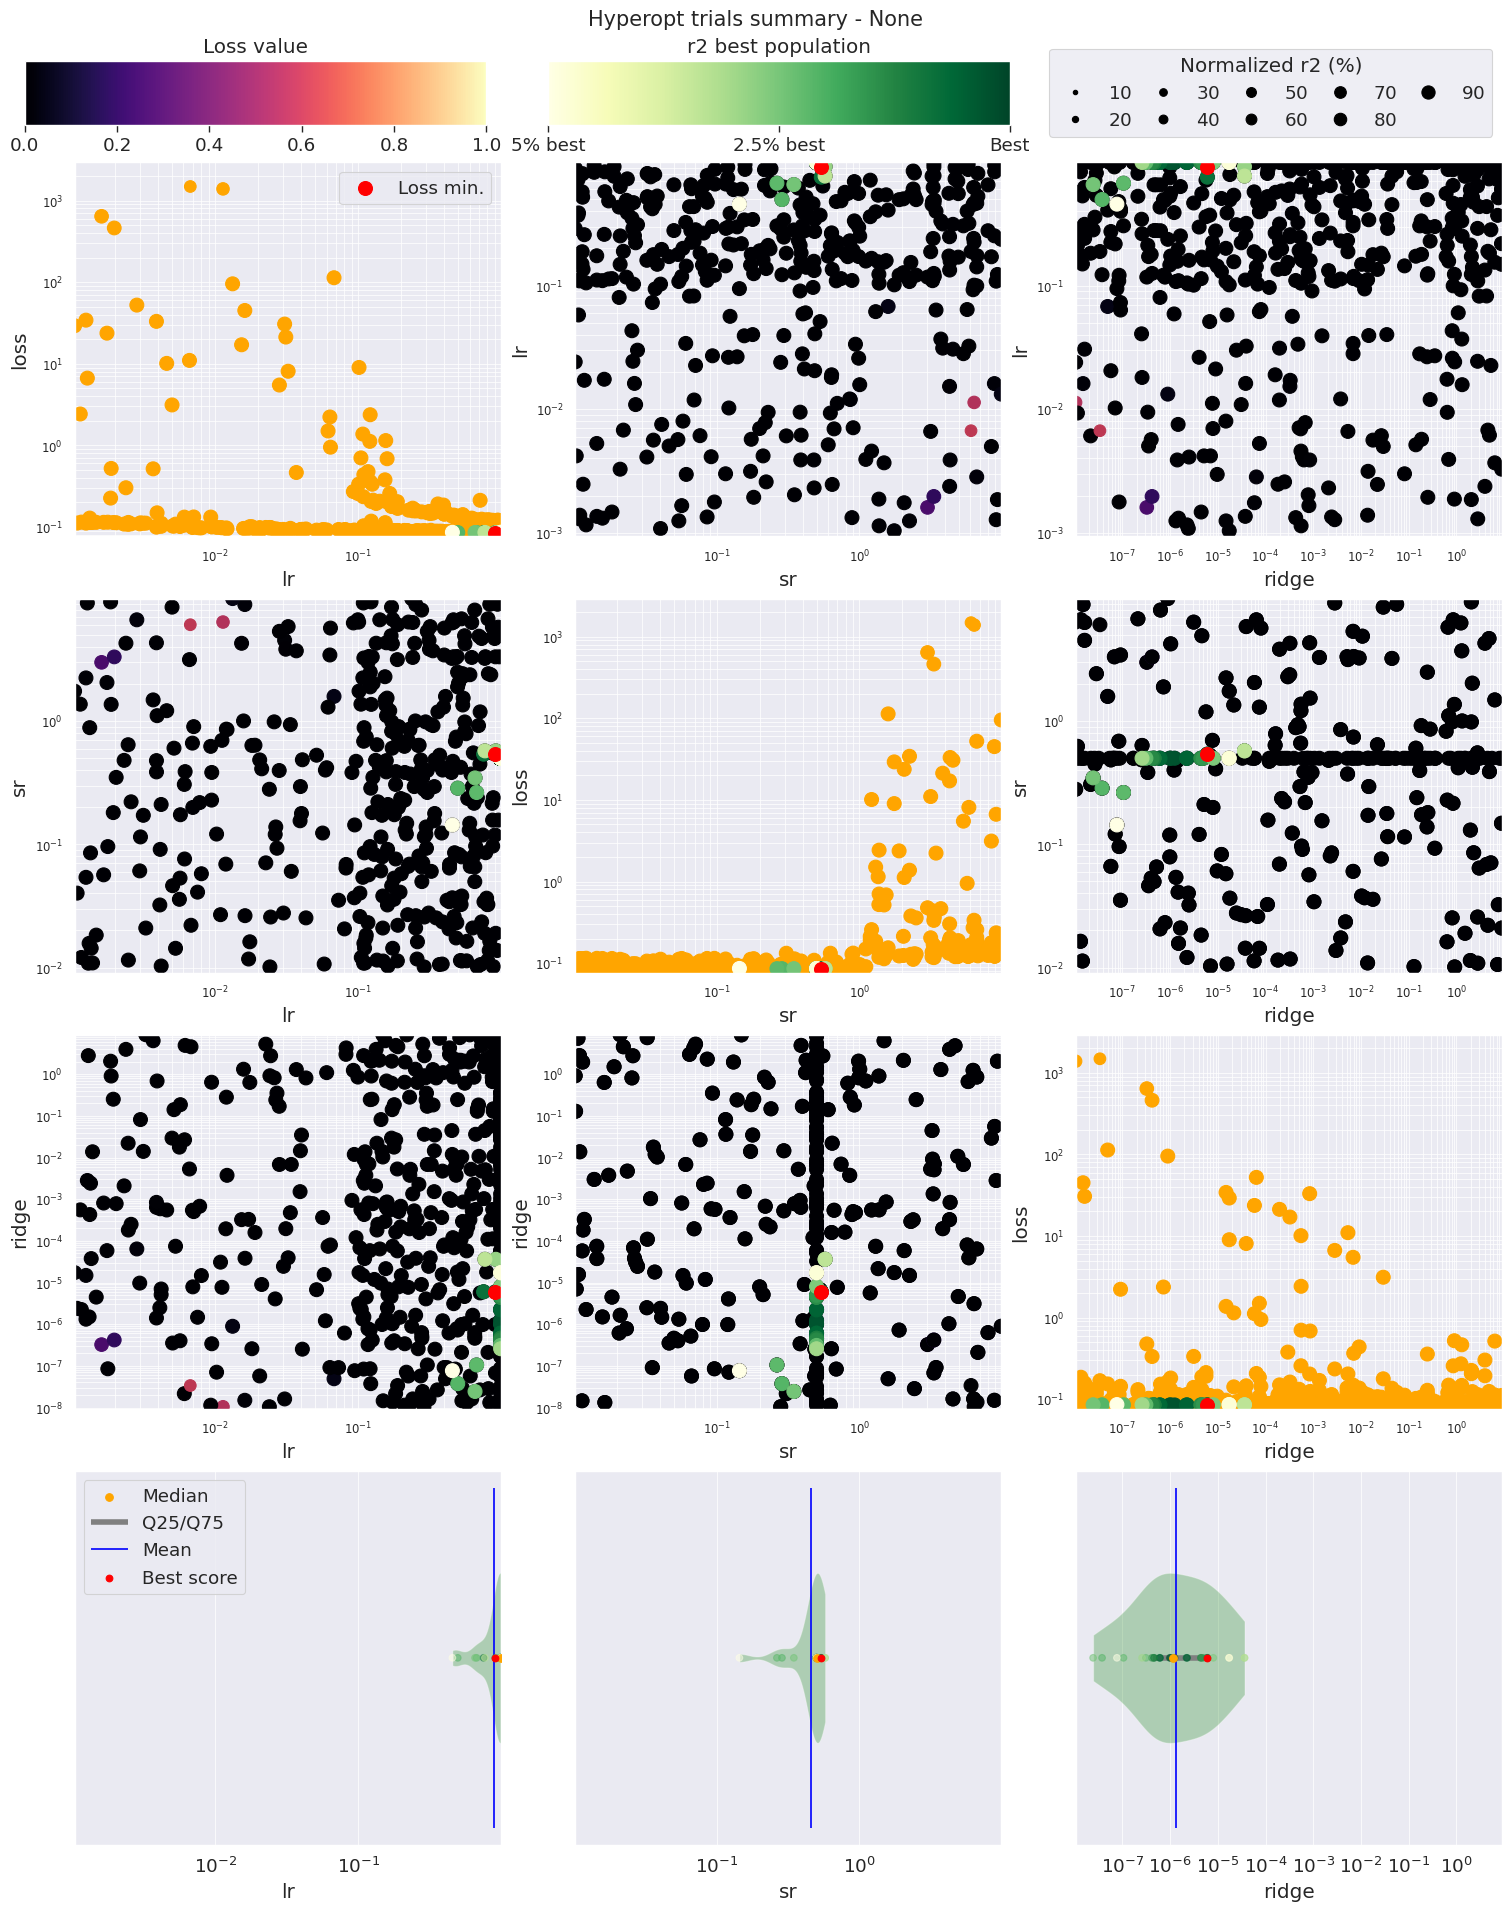

In [170]:
hyperopt_config = {
    "exp": "hyperopt-multiscroll",    # the experimentation name
    "hp_max_evals": 100,              # the number of differents sets of parameters hyperopt has to try
    "hp_method": "random",            # the method used by hyperopt to chose those sets (see below)
    "seed": 96,                       # the random state seed, to ensure reproducibility
    "instances_per_trial": 5,         # how many random ESN will be tried with each sets of parameters
    "hp_space": {                     # what are the ranges of parameters explored
        "N": ["choice", 1000],             # the number of neurons is fixed to 500
        "sr": ["choice", 0.5],   # the spectral radius is log-uniformly distributed between 1e-2 and 10
        "lr": ["choice", 0.99],    # idem with the leaking rate, from 1e-3 to 1
        "input_scaling": ["choice", 1.0], # the input scaling is fixed
        "ridge": ["loguniform", 1e-8, 1e1],        # and so is the regularization parameter.
        "seed": ["choice", 80085]          # an other random seed for the ESN initialization
    }
}

# we precautionously save the configuration in a JSON file
# each file will begin with a number corresponding to the current experimentation run number.
with open(f"{hyperopt_config['exp']}.config.json", "w+") as f:
    json.dump(hyperopt_config, f)

nb_training_points = 5000
nb_test_points = 2000
pas = 10

x_train, x_test, y_train, y_test = generate_data(SET_A, nb_training_points, nb_test_points, pas) 
dataset = (x_train, x_test, y_train, y_test)

best = parallel_research(objective, dataset, f"{hyperopt_config['exp']}.config.json", ".")

fig = plot_hyperopt_report(hyperopt_config["exp"], ("lr", "sr", "ridge"), metric="r2")
plt.show()